In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
''' preprocess data '''

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

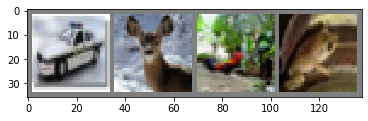

  car  deer  bird  frog


In [3]:
''' show data '''

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # conv + max pooling
        x = self.pool(F.relu(self.conv2(x))) # conv + max pooling 
        x = x.view(x.size(0), -1) # flatten
        
        # fully connected network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [5]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim,activation):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        
        self.query_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim , out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature 
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N) 
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)
        
        out = self.gamma*out + x
        return out,attention

In [6]:
class CNN_Self_Attn_Net(nn.Module):
    def __init__(self):
        super(CNN_Self_Attn_Net, self).__init__()
        self.self_attn = Self_Attn(16, 'relu')
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 30 * 30, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # conv + max pooling
#         x = F.relu(self.conv2(x)) # conv + max pooling
        
        x, attention = self.self_attn(x) # self attention
        
        x = x.view(x.size(0), -1) # flatten
        
        # fully connected network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [7]:
''' test cnn self attn network '''

# build net
cnn_self_attn_net = CNN_Self_Attn_Net()

# get some random training images
dataiter = iter(trainloader)
inputs, labels = dataiter.next()
print(inputs.shape)

# cnn net
outputs = cnn_self_attn_net(inputs)
print(outputs.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 10])


In [8]:
''' training '''

PATH = './cpu_cnn_sa_net.pth'

# build net
net = CNN_Self_Attn_Net()

# load pretraing model
# net.load_state_dict(torch.load(PATH))

# initial loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# training
t0 = time.time()
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

t1 = time.time()
print('Finished Training (CPU)')
print("time: {:f} sec".format(t1 - t0))

# save model
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 1.915
[1,  4000] loss: 1.601
[1,  6000] loss: 1.447
[1,  8000] loss: 1.390
[1, 10000] loss: 1.314
[1, 12000] loss: 1.305
[2,  2000] loss: 1.156
[2,  4000] loss: 1.152
[2,  6000] loss: 1.132
[2,  8000] loss: 1.142
[2, 10000] loss: 1.153
[2, 12000] loss: 1.126
Finished Training (CPU)
time: 1352.186891 sec


In [9]:
''' testing '''

# build net
net = CNN_Self_Attn_Net()

# load pretraining model
net.load_state_dict(torch.load(PATH))

# testing
c = 0
t = 0
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        outputs = net(inputs)
        
        _, predicts = torch.max(outputs, 1)
        
        for p, l in zip(predicts, labels):
            if p == l:
                c+=1
            t+=1

print('acc: {}'.format(c/t))

acc: 0.584


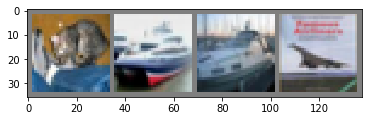

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car plane plane


In [10]:
''' show predict result '''

# load data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# predict images
net = CNN_Self_Attn_Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))